In [1]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from cuml.model_selection import train_test_split
from cuml.svm import SVC as cuSVC
from cuml.ensemble import RandomForestClassifier as cuml_RFClassifier
from cuml.neighbors import KNeighborsClassifier as cumlKNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
import seaborn as sns
import json
import re
import time
import numpy as np
import cudf
import cupy as cp
from urllib.parse import urlparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import tkinter as tk
import customtkinter as ctk
# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
def count_special_chars(url):
    # Implement your logic to count special characters
    special_chars = re.findall(r'[!@#\$%\^&\*\(\)\-\+=]', url)
    return len(special_chars)

def check_url(url, words):
    # Check if URL contains a hyphen
    result = 0
    contains_hyphen = '-' in url
    
    # Check if URL contains any word from the list
    contains_word = any(re.search(rf'\b{word}\b', url) for word in words)
    
    # Return 1 if both conditions are met, else return 0
    if contains_hyphen and contains_word:
        result = 1
    else:
        result = 0
    return result
    
def extract_features(url):
    features = {}
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    features['url_length'] = len(url)
    features['num_digits'] = sum(char.isdigit() for char in url)
    features['num_letters'] = sum(char.isalpha() for char in url)
    features['num_dots'] = url.count(".")
    features['url_depth'] = url.count("/")
    features['contains_https'] = 0 if "https" in url else 1
    features['contains_dash'] = 1 if "-" in url else 0
    features['num_subdomains'] = len(url.split('.')) - 2
    features['num_special_chars'] = count_special_chars(url)
    # Prefix and Suffix lengths
    try:
        if domain in url:
            parts = url.split(domain)
            features['prefix_length'] = len(parts[0])
            features['suffix_length'] = len(parts[1]) if len(parts) > 1 else 0
        else:
            features['prefix_length'] = 0
            features['suffix_length'] = 0
    except:
        features['prefix_length'] = 0
        features['suffix_length'] = 0
    return features

In [3]:
def preprocess_data(df):
    # Handling missing values (NaNs)
    # Ensure numeric columns before filling NaNs with mean
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    # Handling outliers using box plots or other methods
    # Example:
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df


In [4]:
# Plot histograms for features
def plot_histograms(df):
    df.hist(figsize=(12, 10))
    plt.tight_layout()
    plt.show()

def plot_boxplot(df):
    # Box plot to find outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.show()

# Plot heatmap for feature correlations
def plot_heatmap(df):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Features')
    plt.show()

In [5]:
def process_csv(filename):
    # Read the CSV file
    df = pd.read_csv(filename)

    # Extract 'label' column
    labels = df['label']
    df.drop(columns=['label'], inplace=True)
    processing_list = df['url'].tolist()
    processing_features = [extract_features(url) for url in processing_list]
    processing_df = pd.DataFrame(processing_features)
    
    # Append 'label' column back to the DataFrame
    processing_df['label'] = labels
    return processing_df

In [6]:
file1 = 'combined_data5.csv'
processed_data = process_csv(file1)
df = processed_data

In [7]:
if 'label' in df.columns:
    # Count the occurrences of each value in the 'label' column
    counts = df['label'].value_counts()
    
    # Print the counts
    print("Count of 1s: ", counts.get(1, 0))
    print("Count of 0s: ", counts.get(0, 0))
else:
    print("'label' column not found in the DataFrame.")

Count of 1s:  198359
Count of 0s:  174890


In [8]:
# Perform preprocessing
df = preprocess_data(df)
print(len(df))
print(df.head())
print(df.info())
print(df.describe())

291471
   url_length  num_digits  num_letters  num_dots  url_depth  contains_https  \
1          48           0           39         3          3               0   
2          59           0           47         3          5               1   
3          45           5           31         3          5               0   
4          43           0           34         2          4               1   
5          38           0           32         2          3               1   

   contains_dash  num_subdomains  num_special_chars  prefix_length  \
1              1               2                  2              8   
2              0               2                  0              7   
3              0               2                  0              8   
4              0               1                  0              7   
5              0               1                  0              7   

   suffix_length  label  
1             23      0  
2             35      0  
3             24   

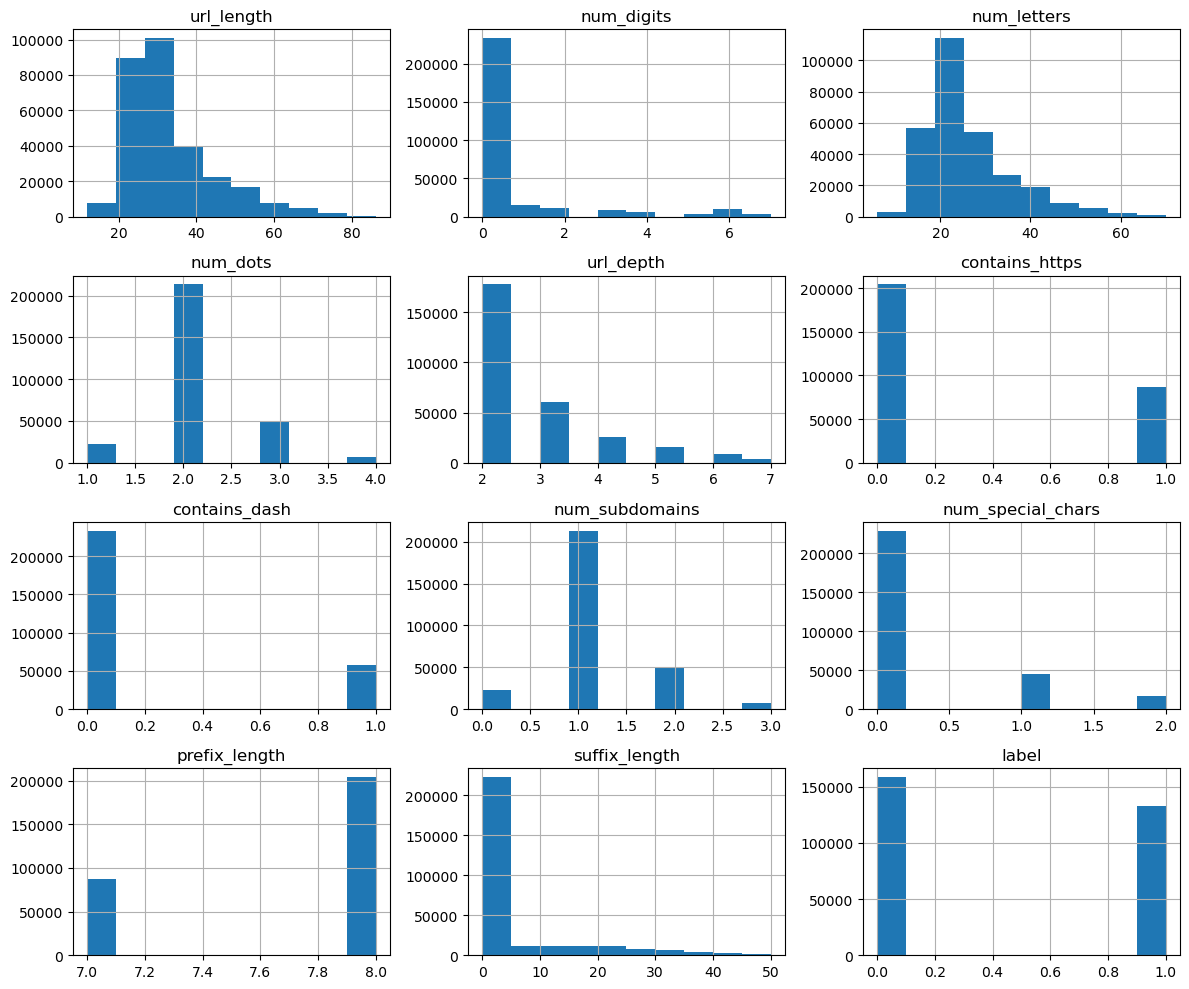

In [9]:
# Plot histograms for features
plt.rcParams['figure.figsize'] = [20, 20]
plot_histograms(df)

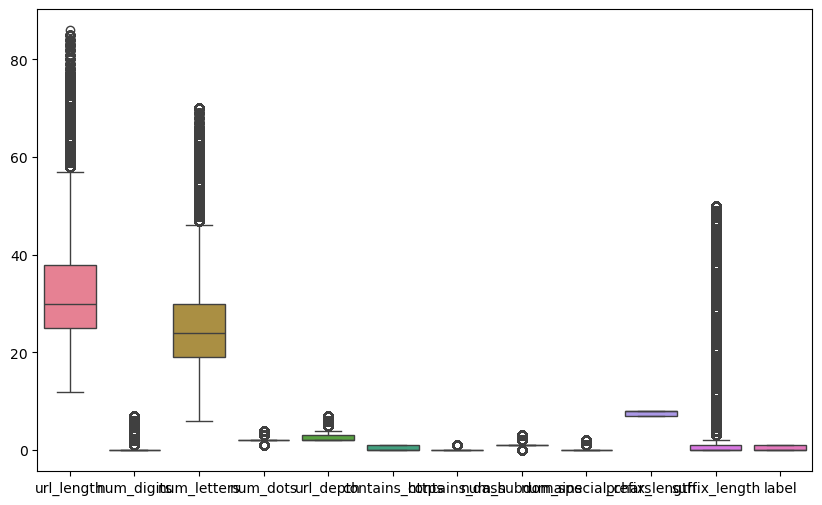

In [10]:
# Plot boxplot for features
plot_boxplot(df)

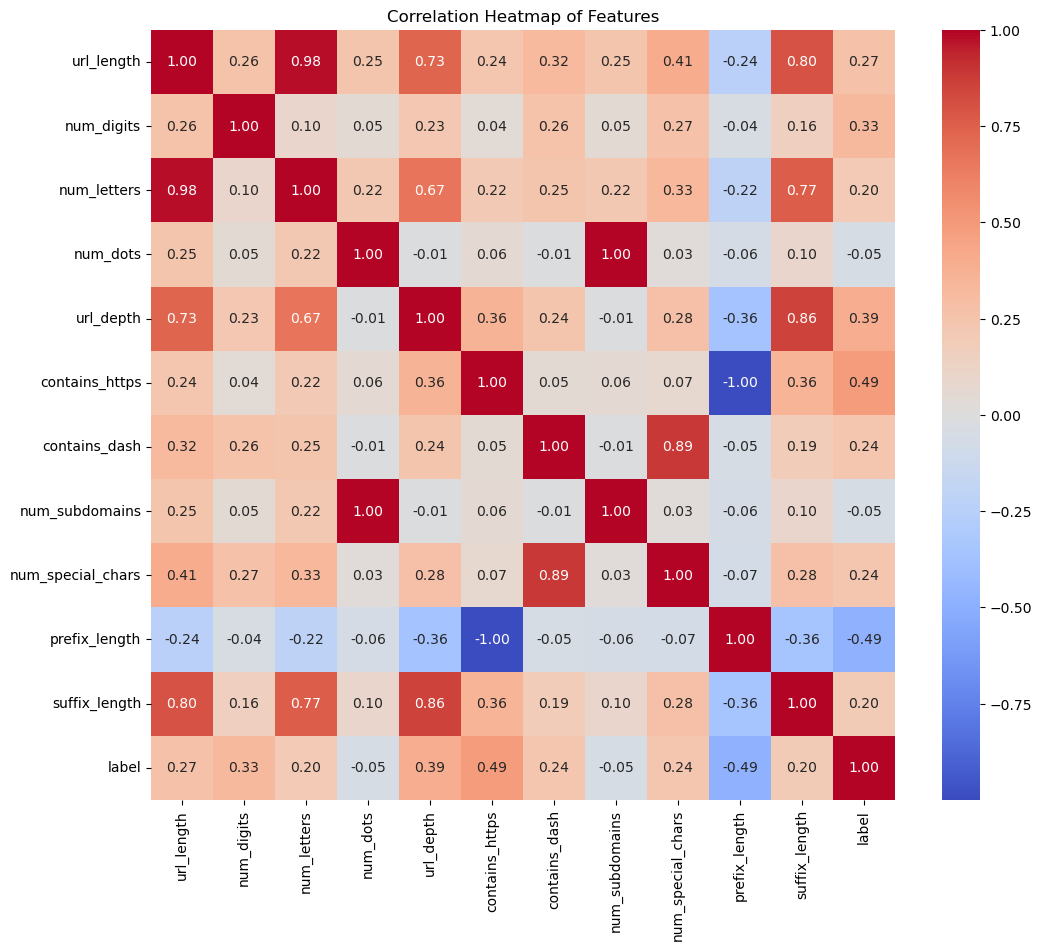

In [11]:
# Plot heatmap for features
plot_heatmap(df)

In [12]:
# Prepare data for model training
X = df.drop('label', axis=1).values
y = df['label'].values

# Scale data if necessary
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)

# Convert features to float32 for compatibility
X = X.astype(np.float32)

In [13]:
# Train-test-validate split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Convert to DataFrame/Series for .iloc usage
X_train, y_train = pd.DataFrame(X_train), pd.Series(y_train)
X_validate, y_validate = pd.DataFrame(X_validate), pd.Series(y_validate)
X_test, y_test = pd.DataFrame(X_test), pd.Series(y_test)

In [14]:
X_train_gpu = cudf.DataFrame.from_pandas(X_train)
y_train_gpu = cudf.Series(y_train)
X_validate_gpu = cudf.DataFrame.from_pandas(X_validate)
y_validate_gpu = cudf.Series(y_validate)
X_test_gpu = cudf.DataFrame.from_pandas(X_test)
y_test_gpu = cudf.Series(y_test)

In [15]:
# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5)
search_space = {
    'svm': [
        Real(1e-6, 1e+6, "log-uniform", name='C'),
    ],
    'random_forest': [
        Integer(10, 500, name='n_estimators'),
        Integer(1, 30, name='max_depth')
    ],
    'gradient_boosting': [
        Integer(10, 500, name='n_estimators'),
        Real(0.01, 1.0, name='learning_rate'),
        Integer(1, 30, name='max_depth')
    ],
    'knn': [
        Integer(1, 20, name='n_neighbors'),
    ]
}
patience = 5  # Number of epochs with no improvement after which training will be stopped
min_delta = 0.001  # Minimum change to qualify as an improvement
max_epochs = 50

In [16]:
# Evaluate the models on the training, validation, and test sets
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_cpu = cp.asnumpy(y)
    y_pred_cpu = cp.asnumpy(y_pred)
    accuracy = accuracy_score(y_cpu, y_pred_cpu)
    conf_matrix = confusion_matrix(y_cpu, y_pred_cpu)
    return accuracy, conf_matrix

In [17]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [18]:
def optimize_svm(params):
    params = {k: v for k, v in zip(['C'], params)}
    model = LinearSVC(**params)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_train_fold.values, y_train_fold.values)
        y_pred = model.predict(X_val_fold.values)
        scores.append(accuracy_score(y_val_fold.values, y_pred))
    return -np.mean(scores)

In [19]:
def optimize_rf(params):
    params = {k: v for k, v in zip(['n_estimators', 'max_depth'], params)}
    model = cuml_RFClassifier(**params)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_train_fold.values, y_train_fold.values)
        y_pred = model.predict(X_val_fold.values)
        scores.append(accuracy_score(y_val_fold.values, y_pred))
    return -np.mean(scores)

In [20]:
def optimize_xgb(params):
    params = {k: v for k, v in zip(['n_estimators', 'learning_rate', 'max_depth'], params)}
    model = xgb.XGBClassifier(device = "cuda", **params)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_train_fold.values, y_train_fold.values)
        y_pred = model.predict(X_val_fold.values)
        scores.append(accuracy_score(y_val_fold.values, y_pred))
    return -np.mean(scores)

In [21]:
def optimize_knn(params):
    params = {k: v for k, v in zip(['n_neighbors', 'weights'], params)}
    # model = cumlKNeighborsClassifier(**params, weights='uniform')
    model = cumlKNeighborsClassifier(**params)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_train_fold.values, y_train_fold.values)
        y_pred = model.predict(X_val_fold.values)
        scores.append(accuracy_score(y_val_fold.values, y_pred))
    return -np.mean(scores)


In [22]:
start_time = time.time()
# Retrieve and train best SVM models
opt_svm = gp_minimize(optimize_svm, search_space['svm'], n_calls=32, random_state=42)
best_svm = LinearSVC(C=opt_svm.x[0])
best_svm.fit(X_train.values, y_train.values)
y_pred_svm = best_svm.predict(X_validate.values)

# Print accuracy reports
print("Validation Accuracy for SVM:", accuracy_score(y_validate.values, y_pred_svm))
print("Classification Report for SVM:\n", classification_report(y_validate.values, y_pred_svm))
end_time = time.time()
total_time = end_time - start_time
print(f"Total Time: {total_time:.4f} seconds")

Validation Accuracy for SVM: 0.8730229526194806
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     15904
           1       0.88      0.83      0.86     13243

    accuracy                           0.87     29147
   macro avg       0.87      0.87      0.87     29147
weighted avg       0.87      0.87      0.87     29147

Total Time: 104.6698 seconds


In [23]:
best_svm_params = dict(zip(['C'], opt_svm.x))
best_svm = LinearSVC(**best_svm_params, random_state=42)
best_svm.fit(X_train_gpu.to_numpy(), y_train_gpu.to_numpy())

LinearSVC(C=64.66386742396142, random_state=42)

In [24]:
svm_train_accuracy, svc_train_cm = evaluate_model(best_svm, X_train, y_train)
svm_val_accuracy, svc_val_cm = evaluate_model(best_svm, X_validate, y_validate)
svm_test_accuracy, svc_test_cm = evaluate_model(best_svm, X_test, y_test)

In [25]:
print(f'SVM - Training Accuracy: {svm_train_accuracy}, Validation Accuracy: {svm_val_accuracy}, Test Accuracy: {svm_test_accuracy}')

SVM - Training Accuracy: 0.8758796965395387, Validation Accuracy: 0.8730229526194806, Test Accuracy: 0.8737777472810238


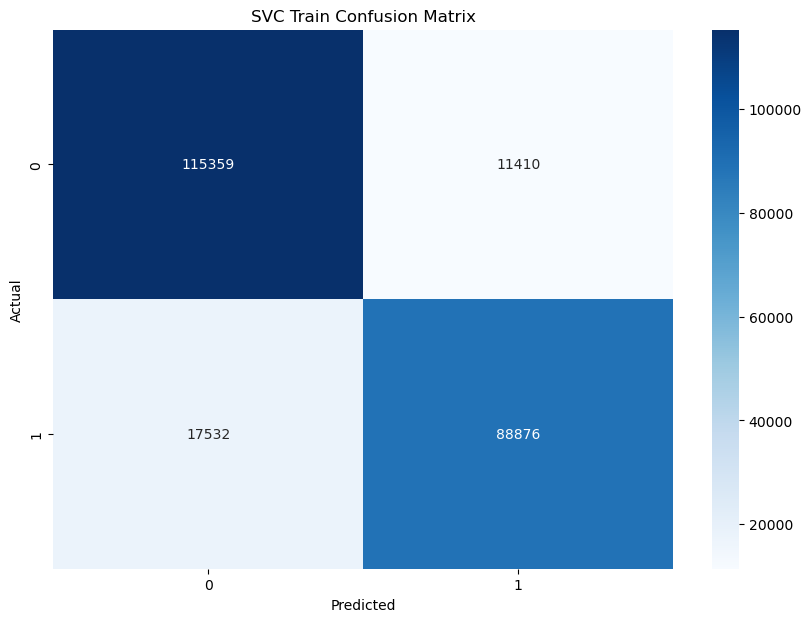

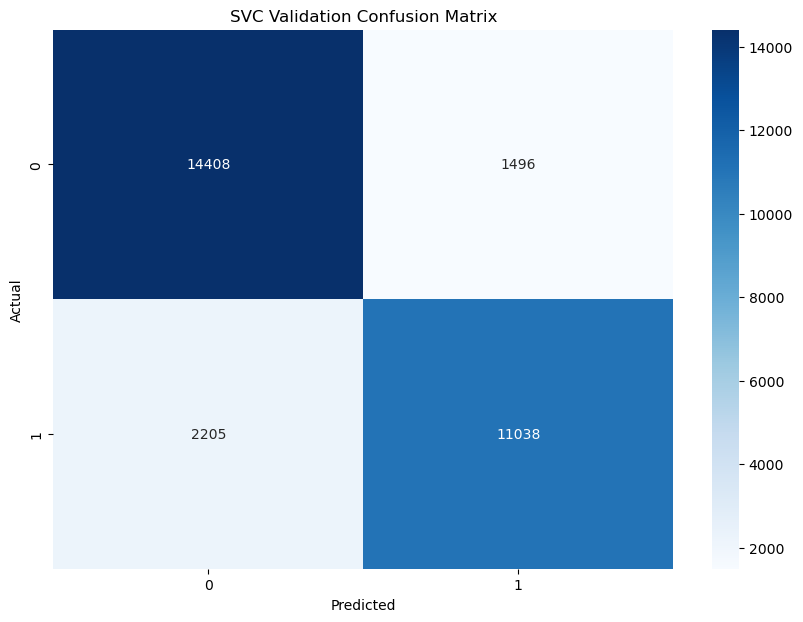

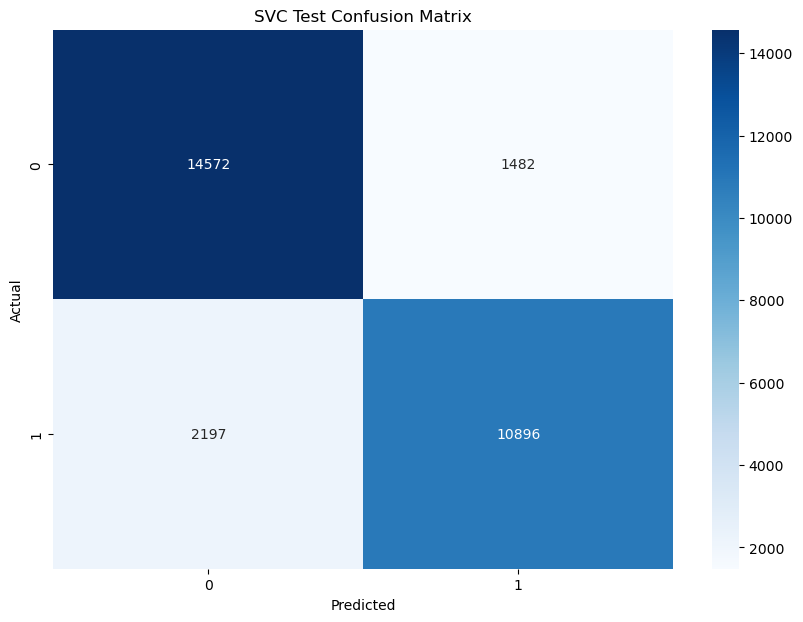

In [26]:
plot_confusion_matrix(svc_train_cm, 'SVC Train Confusion Matrix')
plot_confusion_matrix(svc_val_cm, 'SVC Validation Confusion Matrix')
plot_confusion_matrix(svc_test_cm, 'SVC Test Confusion Matrix')

In [27]:
start_time = time.time()
# Retrieve and train best RF models
opt_rf = gp_minimize(optimize_rf, search_space['random_forest'], n_calls=32, random_state=42)
best_rf = cuml_RFClassifier(n_estimators=opt_rf.x[0], max_depth=opt_rf.x[1])
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_validate)

# Print accuracy reports
print("Validation Accuracy for Random Forest:", accuracy_score(y_validate.values, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_validate.values, y_pred_rf))
end_time = time.time()
total_time = end_time - start_time
print(f"Total Time: {total_time:.4f} seconds")

Validation Accuracy for Random Forest: 0.9456890932171407
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     15904
           1       0.93      0.95      0.94     13243

    accuracy                           0.95     29147
   macro avg       0.94      0.95      0.95     29147
weighted avg       0.95      0.95      0.95     29147

Total Time: 485.6410 seconds


In [28]:
best_rf_params = dict(zip(['n_estimators', 'max_depth'], opt_rf.x))
best_rf = cuml_RFClassifier(**best_rf_params, n_streams=1, random_state=42)
best_rf.fit(X_train_gpu, y_train_gpu)

RandomForestClassifier()

In [29]:
rf_train_accuracy, rf_train_cm = evaluate_model(best_rf, X_train, y_train)
rf_val_accuracy, rf_val_cm = evaluate_model(best_rf, X_validate, y_validate)
rf_test_accuracy, rf_test_cm = evaluate_model(best_rf, X_test, y_test)

In [30]:
print(f'Random Forest - Training Accuracy: {rf_train_accuracy}, Validation Accuracy: {rf_val_accuracy}, Test Accuracy: {rf_test_accuracy}')

Random Forest - Training Accuracy: 0.9568439425843887, Validation Accuracy: 0.9459635640031564, Test Accuracy: 0.9452430781898652


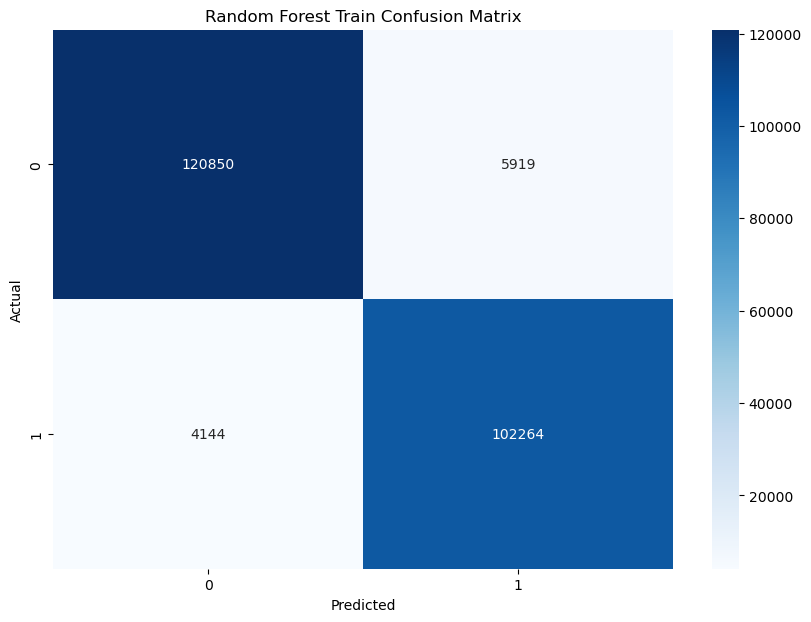

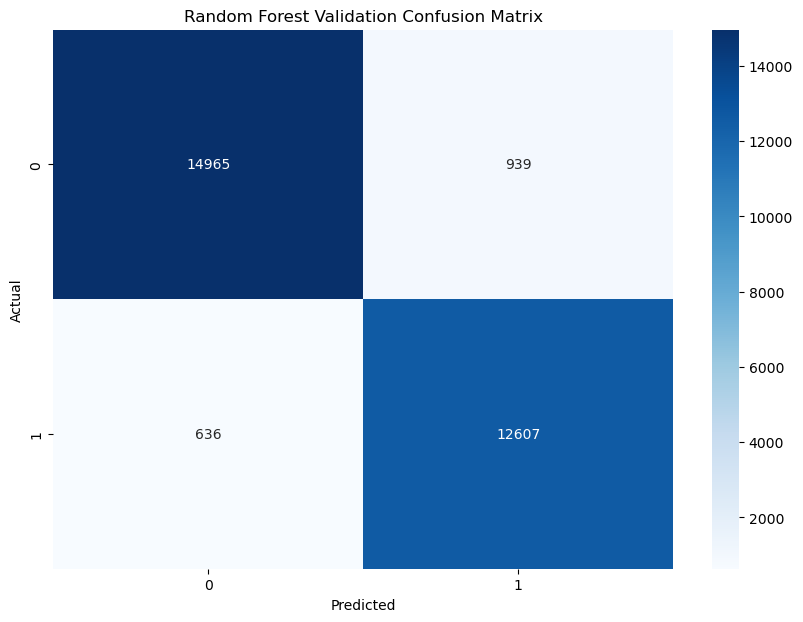

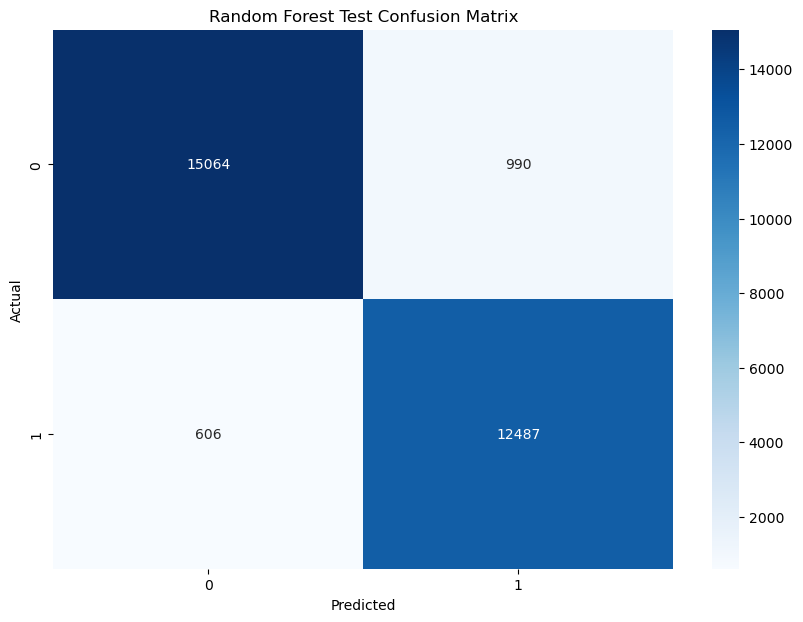

In [31]:
plot_confusion_matrix(rf_train_cm, 'Random Forest Train Confusion Matrix')
plot_confusion_matrix(rf_val_cm, 'Random Forest Validation Confusion Matrix')
plot_confusion_matrix(rf_test_cm, 'Random Forest Test Confusion Matrix')

In [32]:
start_time = time.time()
# Retrieve and train best GB models
opt_xgb = gp_minimize(optimize_xgb, search_space['gradient_boosting'], n_calls=32, random_state=42)
best_xgb = xgb.XGBClassifier(device = "cuda", n_estimators=opt_xgb.x[0], learning_rate=opt_xgb.x[1], max_depth=opt_xgb.x[2])
best_xgb.fit(cp.array(X_train), y_train)
y_pred_xgb = best_xgb.predict(X_validate)

# Print accuracy reports
print("Validation Accuracy for Gradient Boosting:", accuracy_score(y_validate.values, y_pred_xgb))
print("Classification Report for Gradient Boosting:\n", classification_report(y_validate.values, y_pred_xgb))
end_time = time.time()
total_time = end_time - start_time
print(f"Total Time: {total_time:.4f} seconds")

/home/asdf/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:21:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717022039546/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Gradient Boosting: 0.9529282601983051
Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     15904
           1       0.95      0.95      0.95     13243

    accuracy                           0.95     29147
   macro avg       0.95      0.95      0.95     29147
weighted avg       0.95      0.95      0.95     29147

Total Time: 1057.8054 seconds


In [33]:
best_xgb_params = dict(zip(['n_estimators', 'learning_rate', 'max_depth'], opt_xgb.x))
best_xgb = xgb.XGBClassifier(**best_xgb_params, random_state=42)
best_xgb.fit(X_train_gpu, y_train_gpu)

/home/asdf/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06584746323682926,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=22, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=329, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [34]:
xgb_train_accuracy, xgb_train_cm = evaluate_model(best_xgb, X_train.values, y_train.values)
xgb_val_accuracy, xgb_val_cm = evaluate_model(best_xgb, X_validate.values, y_validate.values)
xgb_test_accuracy, xgb_test_cm = evaluate_model(best_xgb, X_test.values, y_test.values)

In [35]:
print(f'XGB - Training Accuracy: {xgb_train_accuracy}, Validation Accuracy: {xgb_val_accuracy}, Test Accuracy: {xgb_test_accuracy}')

XGB - Training Accuracy: 0.9752505607328339, Validation Accuracy: 0.9526880982605413, Test Accuracy: 0.953099804439565


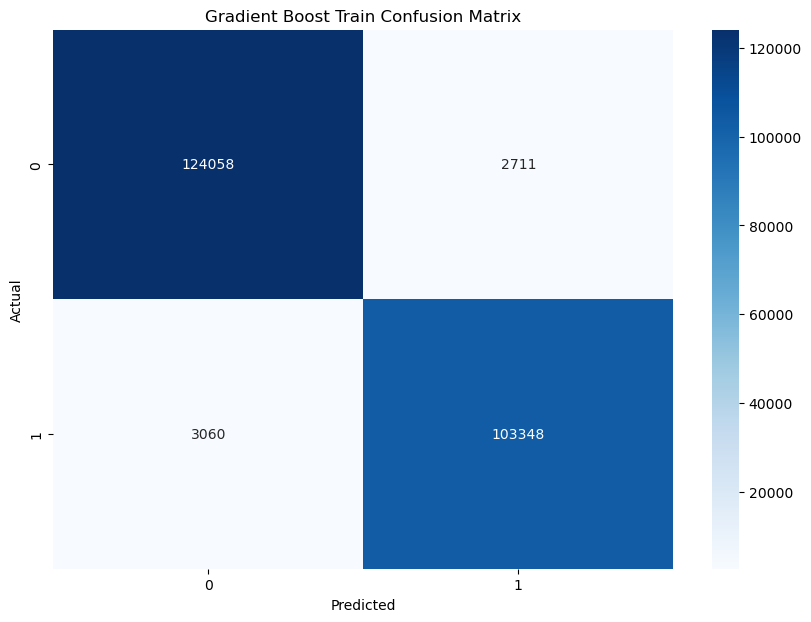

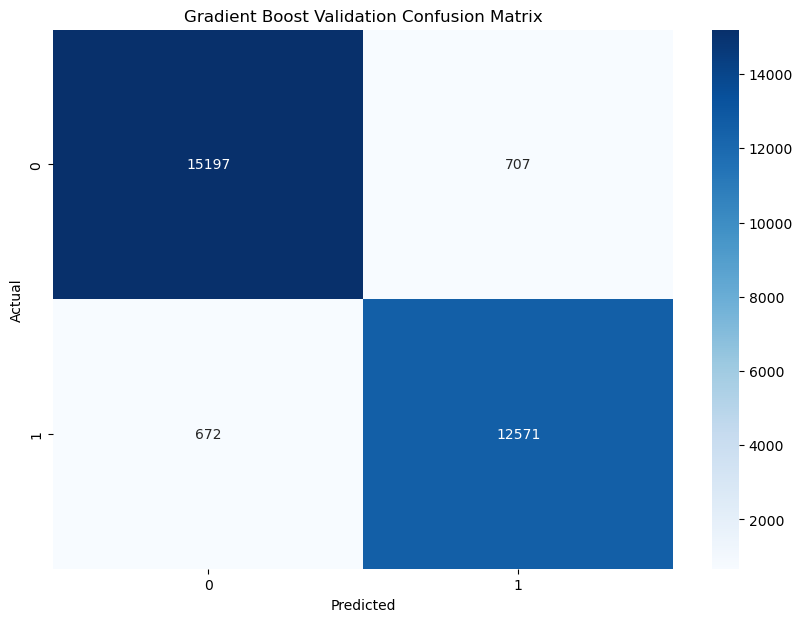

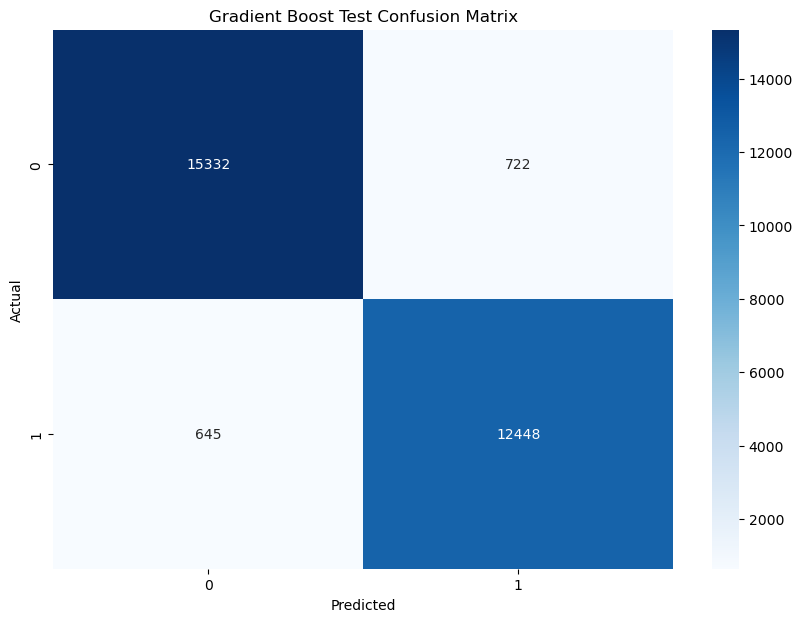

In [36]:
plot_confusion_matrix(xgb_train_cm, 'Gradient Boost Train Confusion Matrix')
plot_confusion_matrix(xgb_val_cm, 'Gradient Boost Validation Confusion Matrix')
plot_confusion_matrix(xgb_test_cm, 'Gradient Boost Test Confusion Matrix')

In [37]:
start_time = time.time()
# Retrieve and train best KNN models
opt_knn = gp_minimize(optimize_knn, search_space['knn'], n_calls=32, random_state=42)
best_knn = cumlKNeighborsClassifier(n_neighbors=opt_knn.x[0], weights='uniform')
best_knn.fit(X_train, y_train)
y_pred_knn = best_knn.predict(X_validate)

# Print accuracy reports
print("Validation Accuracy for KNN:", accuracy_score(y_validate.values, y_pred_knn))
print("Classification Report for KNN:\n", classification_report(y_validate.values, y_pred_knn))
end_time = time.time()
total_time = end_time - start_time
print(f"Total Time: {total_time:.4f} seconds")

/home/asdf/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [8] before, using random point [13]
  warnings.warn(
/home/asdf/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [18] before, using random point [15]
  warnings.warn(
/home/asdf/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15] before, using random point [12]
  warnings.warn(
/home/asdf/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [7] before, using random point [11]
  warnings.warn(
/home/asdf/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at po

Validation Accuracy for KNN: 0.9427385322674717
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     15904
           1       0.93      0.94      0.94     13243

    accuracy                           0.94     29147
   macro avg       0.94      0.94      0.94     29147
weighted avg       0.94      0.94      0.94     29147

Total Time: 21.3964 seconds


In [38]:
best_knn_params = dict(zip(['n_estimators', 'max_depth'], opt_knn.x))
best_knn = cumlKNeighborsClassifier(**best_knn_params, random_state=42)
best_knn.fit(X_train_gpu, y_train_gpu)

[I] [12:39:50.523350] Unused keyword parameter: n_estimators during cuML estimator initialization
[I] [12:39:50.523434] Unused keyword parameter: random_state during cuML estimator initialization


KNeighborsClassifier()

In [39]:
knn_train_accuracy, knn_train_cm = evaluate_model(best_knn, X_train, y_train)
knn_val_accuracy, knn_val_cm = evaluate_model(best_knn, X_validate, y_validate)
knn_test_accuracy, knn_test_cm = evaluate_model(best_knn, X_test, y_test)

In [40]:
print(f'KNN - Training Accuracy: {knn_train_accuracy}, Validation Accuracy: {knn_val_accuracy}, Test Accuracy: {knn_test_accuracy}')

KNN - Training Accuracy: 0.9578646264425736, Validation Accuracy: 0.9427385322674717, Test Accuracy: 0.9445225923765739


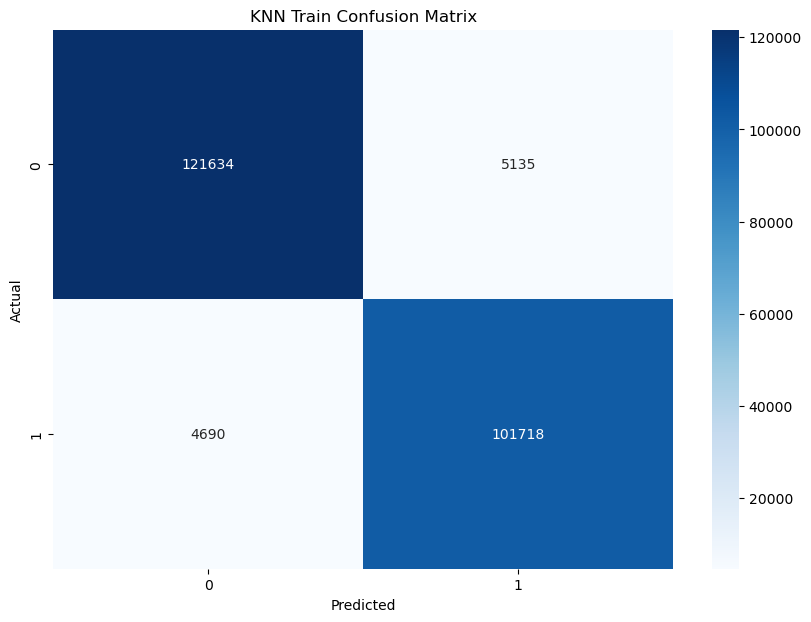

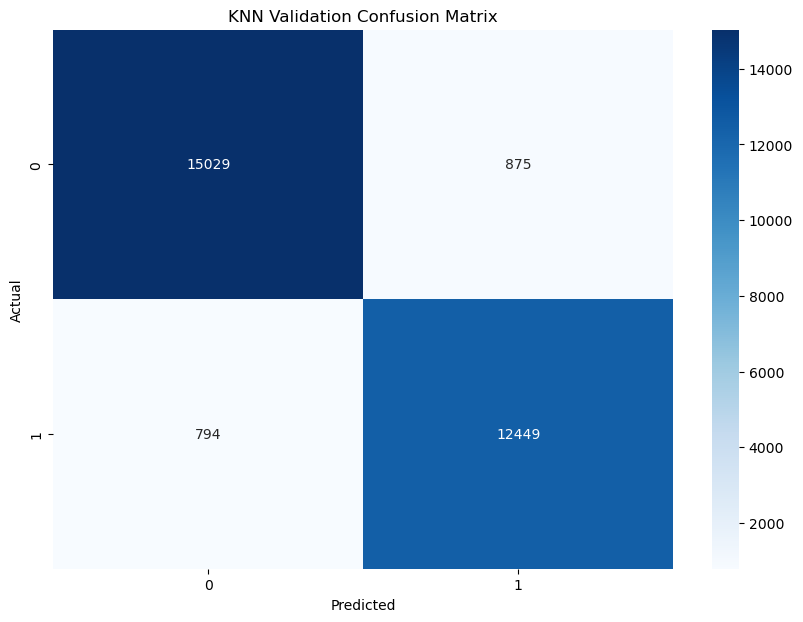

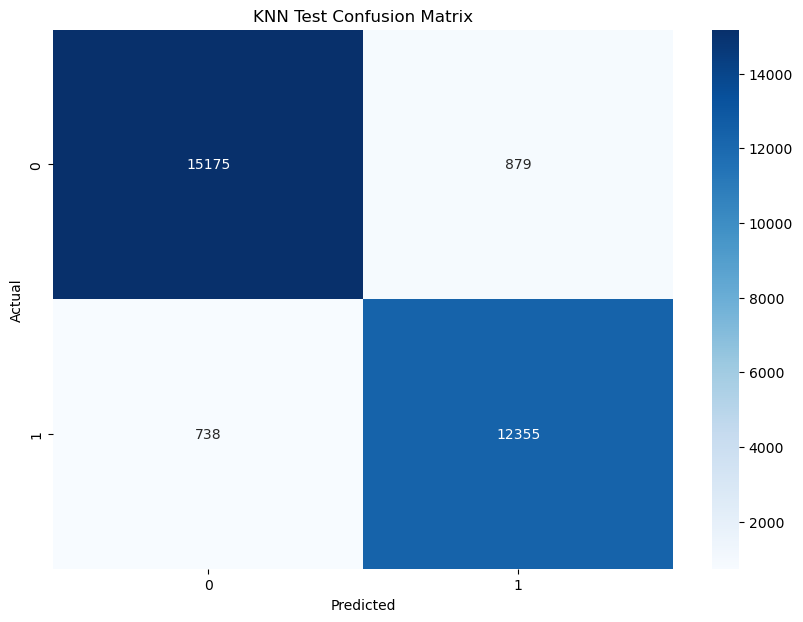

In [41]:
plot_confusion_matrix(knn_train_cm, 'KNN Train Confusion Matrix')
plot_confusion_matrix(knn_val_cm, 'KNN Validation Confusion Matrix')
plot_confusion_matrix(knn_test_cm, 'KNN Test Confusion Matrix')

In [42]:
# Save the SVM model
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)

# Save the XGBoost model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

# Save the Random Forest model
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

# Save the KNN model
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(best_knn, file)

In [44]:
import tkinter as tk
import customtkinter as ctk
import pickle
import re
from urllib.parse import urlparse
import numpy as np

# Create the application window
app = ctk.CTk()
app.geometry("600x500")
app.title("Phishing URL Detection")

# Load the models
with open('svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)
with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)
with open('rf_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)
with open('knn_model.pkl', 'rb') as file:
    knn_model = pickle.load(file)

# Define the custom feature extraction functions
def count_special_chars(url):
    # Implement your logic to count special characters
    special_chars = re.findall(r'[!@#\$%\^&\*\(\)\-\+=]', url)
    return len(special_chars)

def check_url(url, words):
    # Check if URL contains a hyphen
    result = 0
    contains_hyphen = '-' in url
    
    # Check if URL contains any word from the list
    contains_word = any(re.search(rf'\b{word}\b', url) for word in words)
    
    # Return 1 if both conditions are met, else return 0
    if contains_hyphen and contains_word:
        result = 1
    else:
        result = 0
    return result

def extract_features(url):
    features = {}
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    
    # Extract features from the URL
    features['url_length'] = len(url)
    features['num_digits'] = sum(char.isdigit() for char in url)
    features['num_letters'] = sum(char.isalpha() for char in url)
    features['num_dots'] = url.count(".")
    features['url_depth'] = url.count("/")
    features['contains_https'] = 0 if "https" in url else 1
    features['contains_dash'] = 1 if "-" in url else 0
    features['num_subdomains'] = len(url.split('.')) - 2
    features['num_special_chars'] = count_special_chars(url)
    
    # Prefix and Suffix lengths
    try:
        if domain in url:
            parts = url.split(domain)
            features['prefix_length'] = len(parts[0])
            features['suffix_length'] = len(parts[1]) if len(parts) > 1 else 0
        else:
            features['prefix_length'] = 0
            features['suffix_length'] = 0
    except:
        features['prefix_length'] = 0
        features['suffix_length'] = 0
        
    return list(features.values())  # Return feature values as a list

# UI layout: Title
title = ctk.CTkLabel(app, text="Enter a URL to check for phishing:", font=("Arial", 24, "bold"))
title.pack(pady=20)

# UI layout: URL entry field
url_entry = ctk.CTkEntry(app, width=500)
url_entry.pack(pady=10)

# UI layout: Output label for overall result
output_label = ctk.CTkLabel(app, text="", font=("Arial", 18, "bold"), fg_color=("gray", "white"), corner_radius=8)
output_label.pack(pady=20)

# UI layout: Individual model result labels
svm_label = ctk.CTkLabel(app, text="SVM: ", font=("Arial", 18, "bold"))
svm_label.pack(pady=5)

xgb_label = ctk.CTkLabel(app, text="XGBoost: ", font=("Arial", 18, "bold"))
xgb_label.pack(pady=5)

rf_label = ctk.CTkLabel(app, text="Random Forest: ", font=("Arial", 18, "bold"))
rf_label.pack(pady=5)

knn_label = ctk.CTkLabel(app, text="KNN: ", font=("Arial", 18, "bold"))
knn_label.pack(pady=5)

# Function to check the URL against the models
def check_url_action():
    url = url_entry.get()
    
    if not url:
        output_label.configure(text="Please enter a URL!", text_color="red")
        return
    
    # Extract features from the URL
    features = extract_features(url)
    features = np.array([features])  # Convert to 2D array for model input
    
    # Make predictions using the loaded models
    svm_pred = svm_model.predict(features)[0]
    xgb_pred = xgb_model.predict(features)[0]
    rf_pred = rf_model.predict(features)[0]
    knn_pred = knn_model.predict(features)[0]

    # Display the result of each model
    svm_label.configure(text=f"SVM: {'Phishing' if svm_pred == 1 else 'Safe'}", text_color=("red" if svm_pred == 1 else "green"))
    xgb_label.configure(text=f"XGBoost: {'Phishing' if xgb_pred == 1 else 'Safe'}", text_color=("red" if xgb_pred == 1 else "green"))
    rf_label.configure(text=f"Random Forest: {'Phishing' if rf_pred == 1 else 'Safe'}", text_color=("red" if rf_pred == 1 else "green"))
    knn_label.configure(text=f"KNN: {'Phishing' if knn_pred == 1 else 'Safe'}", text_color=("red" if knn_pred == 1 else "green"))

    # Collect predictions and analyze
    predictions = np.array([svm_pred, xgb_pred, rf_pred, knn_pred])
    phishing_count = np.sum(predictions)  # Count how many models predict "phishing" (1)

    # Display overall results based on majority vote
    if phishing_count >= 3:
        output_label.configure(text="This URL is likely PHISHING!", text_color="red")
    else:
        output_label.configure(text="This URL seems SAFE.", text_color="green")

# UI layout: Check button
check_button = ctk.CTkButton(app, text="Check URL", command=check_url_action, width=200)
check_button.pack(pady=20)

# Run the application
app.mainloop()


invalid command name "139631299295296update"
    while executing
"139631299295296update"
    ("after" script)
invalid command name "139631320883456check_dpi_scaling"
    while executing
"139631320883456check_dpi_scaling"
    ("after" script)
